In [1]:
# 구글 drive 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import Dataset

from PIL import Image
from tqdm import tqdm 
import cv2

from torchvision.utils import save_image
import torch
import torchvision

In [3]:
# 데이터 갯수 확인
path = '/content/drive/MyDrive/vzen2/data_prepared'

train_data = os.listdir(os.path.join(path,'train'))
val_data = os.listdir(os.path.join(path,'val'))
test_data = os.listdir(os.path.join(path,'test'))
print(f'train_data:{len(train_data)} | val_data:{len(val_data)} | test_data:{len(test_data)}')

train_data:210 | val_data:90 | test_data:60


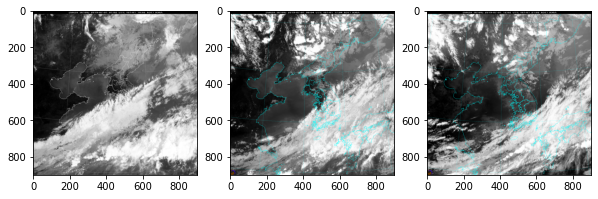

In [4]:
## 시각화
plt.figure(figsize=(10,15))
plt.subplot(131)
train_img = cv2.imread(os.path.join(path,'train',train_data[0]))
train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)
plt.imshow(train_img, cmap='gray')

plt.subplot(132)
val_img = cv2.imread(os.path.join(path,'val', val_data[0]))
plt.imshow(val_img)

plt.subplot(133)
test_img = cv2.imread(os.path.join(path,'test', test_data[0]))
plt.imshow(test_img)

plt.show()

In [5]:
# 경로 변경
%cd /content/drive/MyDrive/vzen2

/content/drive/MyDrive/vzen2


In [6]:
## 데이터 로더를 구현하기
class Dataset(Dataset):
    def __init__(self, data_dir, time_step, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        list_data = os.listdir(self.data_dir)
        # 2분 간격이기 때문에 input 이미지 다음 30번 째 이미지가 1시간 후 이미지
        # train 폴더 index 0 ~ 마지막 index - time_step
        # list_input = [list_data[i] for i in range(9970)]
        list_input = [list_data[i] for i in range(len(list_data) - time_step)]
        # train 폴더 index 30 ~ 9999
        list_label = [list_data[i] for i in range(time_step, len(list_data))]
        
        list_input.sort()
        list_label.sort()
        
        self.list_input = list_input
        self.list_label = list_label

    def __len__(self):
        return len(self.list_label)

    def __getitem__(self, index):
        
        label = Image.open(os.path.join(self.data_dir, self.list_label[index]))
        input = Image.open(os.path.join(self.data_dir, self.list_input[index]))

        if self.transform:
            input = self.transform(input)
            label = self.transform(label)

        data = {'input': input, 'label': label}
        return data
     

In [7]:
## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path(endocer)
        self.enc1_1 = CBR2d(in_channels=4, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path(decoder)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=4, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):

        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)
 

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        # dim = [0:batch, 1:channel, 2:height, 3:width]
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [8]:
pwd

'/content/drive/MyDrive/vzen2'

In [9]:
## 트레이닝 파라메터 설정하기

lr = 1e-3
batch_size = 4
num_epoch = 50

data_dir = './data_prepared/'
ckpt_dir = './checkpoint/'
log_dir = './log/'
result_dir = './results'

if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))

# 2분 간격이기 때문에 30step = 1시간
time_step = 30

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# device = torch.device('cpu')

cuda


In [10]:
## 네트워크 학습하기
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5)                        
    ])


transform_test = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),                   
    ])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), time_step=time_step, transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), time_step=time_step, transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0)

dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test'), time_step=time_step, transform=transform_test)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

In [11]:
## 네트워크 생성하기
net = UNet().to(device)

In [12]:
## 손실함수 정의하기
fn_loss = nn.BCEWithLogitsLoss().to(device)

In [13]:
## optimizer 설정하기
optim = torch.optim.Adam(net.parameters(), lr=lr)

In [14]:
## 그 밖에 부수적인 variables 설정
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)
num_data_test = len(dataset_test)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)
num_batch_test = np.ceil(num_data_test / batch_size)

In [15]:
# ## 그 밖에 부수적인 function 설정
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0,2,3,1)

In [16]:
## 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(), 
                'optim': optim.state_dict(),
               'epoch': epoch},
                f'./{ckpt_dir}/model_epoch{epoch}.pth')
    

In [36]:
## 네트워크 불러오기
def load(ckpt_dir, net, optim, epoch=None):
    if not os.path.exists(ckpt_dir):
        epoch=0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort()
    ckpt_lst.sort(key = lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load(f'./{ckpt_dir}/{ckpt_lst[-1]}')

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = dict_model['epoch']
    
    return net, optim, epoch

In [37]:
## 네트워크 불러오기
def test_load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch=0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key = lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load(f'./{ckpt_dir}/{ckpt_lst[-1]}')

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])

    return net, optim

In [38]:
## 네트워크 학습하기
st_epoch = 0
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

final_loss = 100
for epoch in tqdm(range(st_epoch + 1, num_epoch + 1)):
    net.train()
    loss_arr = []

    for batch, data in enumerate(loader_train, 1):
        #forward
        label = data['label'].to(device)
        input = data['input'].to(device)
        output = net(input)

        # backward
        optim.zero_grad()

        loss = fn_loss(output, label)
        loss.backward()

        optim.step()

        # 손실함수 계산
        loss_arr += [loss.item()]

        print(f'TRAIN: EPOCH {epoch} / {num_epoch} | batch {batch} / {num_batch_train} | LOSS {np.mean(loss_arr):.4f}')

    with torch.no_grad():
        net.eval()
        loss_arr = []

        for batch, data in enumerate(loader_val, 1):
            # forward
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # 손실함수 계산
            loss = fn_loss(output, label)
            loss_arr += [loss.item()]

            print(f'VALID: EPOCH {epoch} / {num_epoch} | batch {batch} / {num_batch_val} | LOSS {np.mean(loss_arr):.4f}')

    epoch_loss = np.mean(loss_arr)
    if final_loss > epoch_loss:
      save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)
      final_loss = epoch_loss


  0%|          | 0/20 [00:00<?, ?it/s]

TRAIN: EPOCH 31 / 50 | batch 1 / 45.0 | LOSS 0.5104
TRAIN: EPOCH 31 / 50 | batch 2 / 45.0 | LOSS 0.4995
TRAIN: EPOCH 31 / 50 | batch 3 / 45.0 | LOSS 0.5038
TRAIN: EPOCH 31 / 50 | batch 4 / 45.0 | LOSS 0.5051
TRAIN: EPOCH 31 / 50 | batch 5 / 45.0 | LOSS 0.5013
TRAIN: EPOCH 31 / 50 | batch 6 / 45.0 | LOSS 0.5024


  0%|          | 0/20 [00:18<?, ?it/s]


KeyboardInterrupt: ignored

In [27]:
# TEST
st_epoch = 0
net, optim = test_load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
    net.eval()
    loss_arr = []

    for batch, data in enumerate(loader_test, 1):
        # forward
        label = data['label'].to(device)
        input = data['input'].to(device)

        output = net(input)

        # 손실함수 계산
        loss = fn_loss(output, label)
        loss_arr += [loss.item()]

        print(f'TEST:batch {batch} / {num_batch_test} | LOSS {np.mean(loss_arr):.4f}')

        label = fn_tonumpy(label)
        input = fn_tonumpy(input)
        output = fn_tonumpy(output)



TEST:batch 1 / 8.0 | LOSS 0.4626
TEST:batch 2 / 8.0 | LOSS 0.4629
TEST:batch 3 / 8.0 | LOSS 0.4631
TEST:batch 4 / 8.0 | LOSS 0.4632
TEST:batch 5 / 8.0 | LOSS 0.4633
TEST:batch 6 / 8.0 | LOSS 0.4633
TEST:batch 7 / 8.0 | LOSS 0.4634
TEST:batch 8 / 8.0 | LOSS 0.4633


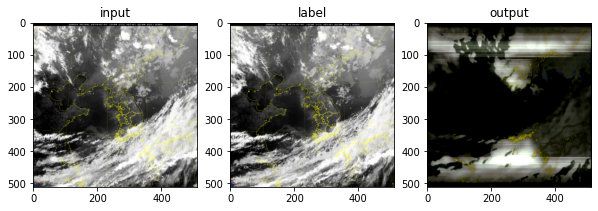

In [31]:
plt.figure(figsize=(10,8))
plt.subplot(131)
plt.title('input')
plt.imshow(input[0])
plt.subplot(132)
plt.title('label')
plt.imshow(label[0])
plt.subplot(133)
plt.title('output')
plt.imshow(output[0])
plt.show()